In [33]:
import torch, utils
from torch import nn
from attention_functions import MultiHeadAttention
import matplotlib.pyplot as plt
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

### 位置编码
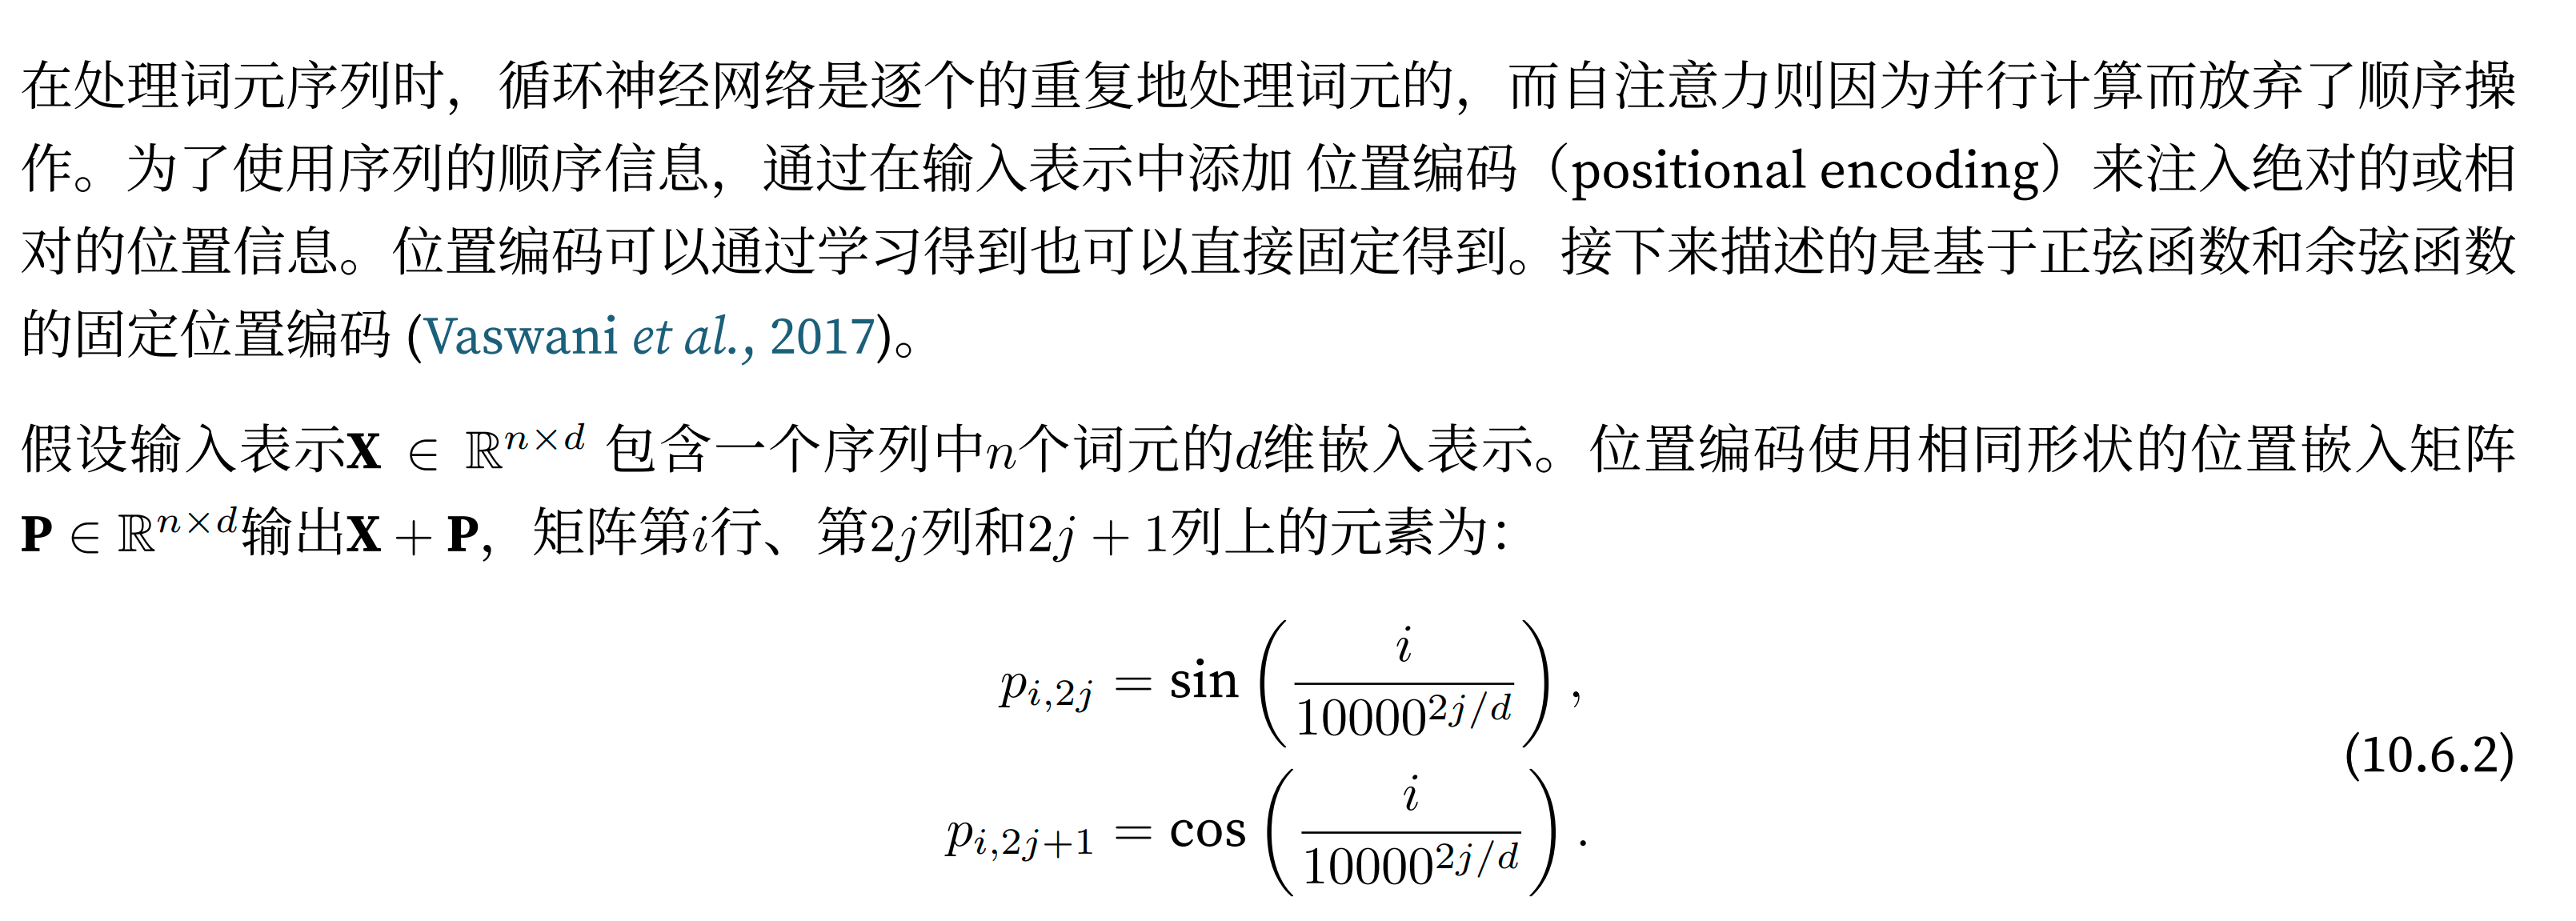

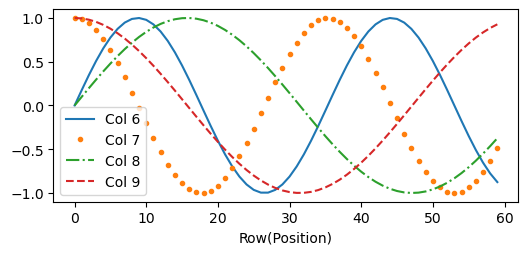

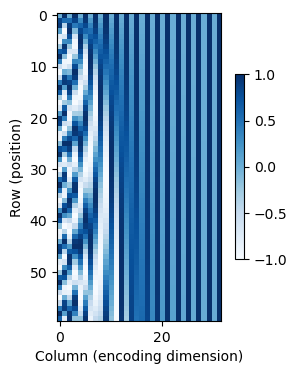

In [35]:
class PositionalEncoding(nn.Module):
    """
    位置编码:
    在完全依赖于注意力机制的模型中， 为了并行计算, 序列的位置信息会被忽略
    位置编码的目的就是给予模型词元的位置信息
    """
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        # P是位置编码矩阵, 存储序列中每个位置的位置编码信息, 这些编码之后会被添加到输入embedding中

        self.P = torch.zeros((1, max_len, num_hiddens)) # 长度为1的第一维为了广播机制
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X) # 奇数索引位置编码
        self.P[:, :, 1::2] = torch.cos(X) # 偶数索引位置编码

    def forward(self, X):
        """
        X : shape=(batch_size, seq_len, num_hiddens)
        """
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
plt.figure(figsize=(6, 2.5))
for row, legend_name, style in zip(P[0, :, 6:10].T, [f"Col {d}" for d in torch.arange(6, 10)], ['-', '.', '-.', '--']):
    plt.plot(torch.arange(num_steps), row, style, label=legend_name)
plt.legend()
plt.xlabel('Row(Position)')

"""
三角函数编码相对于二进制编码的优点
在二进制表示中，较高比特位的交替频率低于较低比特位，与下面的热图所示相似，只是位置编码通过使用
三角函数在编码维度上降低频率。由于输出是浮点数，因此此类连续表示比二进制表示法更节省空间。
"""
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
utils.show_heatmaps(P, xlabel='Column (encoding dimension)', ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')
